# Lattice Hop Detection: Quantization vs Real Movement

For each timestep, we count how many tokens made **lattice-scale displacements**—movements small enough to be just bfloat16 quantization jitter rather than meaningful gradient-driven updates.

## Method

1. For each token at time $t$, compute local ULP based on its current position
2. Compute threshold: $\epsilon = 8 \times \text{ULP}$ (worst-case 64D diagonal)
3. Measure displacement: $\|w_{t+1} - w_t\|$
4. If displacement $< \epsilon$, classify as "lattice hop" (quantization noise)
5. Otherwise, classify as "real movement" (gradient update)

Output: For each timestep, count of tokens that made lattice-scale hops (0 to 50,257).

## Parameters

In [54]:
TENSOR_PATH = '../tensors/Wordybird/1.12f_wordybird_1b.safetensors'
EPSILON_MULTIPLIER = 8  # sqrt(64) for worst-case diagonal in 64D
RANDOM_SEED = 42

## Imports

In [55]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors import safe_open
from pathlib import Path
from tqdm import tqdm

## Device Detection

In [56]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Helper Functions

In [57]:
def get_max_exponents_vectorized(vectors_bf16):
    """
    Get the maximum exponent across all dimensions for a batch of bfloat16 vectors.
    
    Args:
        vectors_bf16: (N, D) tensor of bfloat16 values (on any device)
    
    Returns:
        Tensor of shape (N,) with maximum exponent for each vector
    """
    # Shape: (N, D)
    values_uint16 = vectors_bf16.view(torch.int16).to(torch.int64) & 0xFFFF
    exponents = (values_uint16 >> 7) & 0xFF
    # Max across dimensions, shape: (N,)
    return exponents.max(dim=1).values

def compute_ulp_at_exponents_vectorized(exponents):
    """
    Compute ULP (unit in last place) for bfloat16 at given exponents (vectorized).
    
    Args:
        exponents: Tensor of shape (N,) with exponent values
        
    Returns:
        Tensor of shape (N,) with ULP values
    
    bfloat16 has 7 mantissa bits, so ULP = 2^(exponent - 127 - 7) = 2^(exponent - 134)
    """
    return 2.0 ** (exponents.float() - 134)

print("✓ Helper functions defined")

✓ Helper functions defined


## Load Data

In [58]:
# Load embeddings only (we just need positions)
with safe_open(TENSOR_PATH, framework='pt', device='cpu') as f:
    W = f.get_tensor('embeddings').to(device)  # [101, 50257, 64]

n_steps, n_tokens, n_dims = W.shape

print(f"Loaded embeddings: {W.shape}")
print(f"Analyzing {n_steps} timesteps, {n_tokens:,} tokens, {n_dims} dimensions")
print(f"Device: {W.device}")

Loaded embeddings: torch.Size([201, 50257, 64])
Analyzing 201 timesteps, 50,257 tokens, 64 dimensions
Device: mps:0


## Step 1: Detect Lattice Hops Per Timestep

For each timestep transition $t \to t+1$, count tokens whose displacement is smaller than their local lattice threshold.

In [59]:
lattice_hop_counts = []
real_movement_counts = []
mean_displacements = []
median_displacements = []

with torch.no_grad():
    for t in tqdm(range(n_steps - 1), desc="Analyzing timesteps"):
        # Get positions at t and t+1
        W_t = W[t]      # [50257, 64]
        W_t1 = W[t+1]   # [50257, 64]
        
        # Compute displacements (vectorized)
        displacements = torch.linalg.norm(W_t1 - W_t, dim=1)  # [50257]
        
        # Compute ULP thresholds for all tokens at once (vectorized)
        max_exps = get_max_exponents_vectorized(W_t)  # [50257]
        ulps = compute_ulp_at_exponents_vectorized(max_exps)  # [50257]
        epsilons = ulps * EPSILON_MULTIPLIER  # [50257]
        
        # Single vectorized comparison
        lattice_hop_mask = displacements < epsilons  # [50257] bool tensor
        
        # Count and record
        n_lattice_hops = lattice_hop_mask.sum().item()
        n_real_movement = n_tokens - n_lattice_hops
        
        lattice_hop_counts.append(n_lattice_hops)
        real_movement_counts.append(n_real_movement)
        mean_displacements.append(displacements.mean().item())
        median_displacements.append(displacements.median().item())

# Convert to numpy for plotting
lattice_hop_counts = np.array(lattice_hop_counts)
real_movement_counts = np.array(real_movement_counts)
mean_displacements = np.array(mean_displacements)
median_displacements = np.array(median_displacements)

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Average lattice hops per timestep: {lattice_hop_counts.mean():.1f} ({100*lattice_hop_counts.mean()/n_tokens:.2f}%)")
print(f"Average real movements per timestep: {real_movement_counts.mean():.1f} ({100*real_movement_counts.mean()/n_tokens:.2f}%)")
print(f"\nTimestep with most lattice hops: {lattice_hop_counts.argmax()} ({lattice_hop_counts.max()} tokens)")
print(f"Timestep with most real movement: {real_movement_counts.argmax()} ({real_movement_counts.max()} tokens)")

Analyzing timesteps: 100%|██████████| 200/200 [00:00<00:00, 456.16it/s]


SUMMARY
Average lattice hops per timestep: 38939.5 (77.48%)
Average real movements per timestep: 11317.5 (22.52%)

Timestep with most lattice hops: 156 (50257 tokens)
Timestep with most real movement: 0 (50257 tokens)


## Step 2: Visualize Lattice Hops Over Time

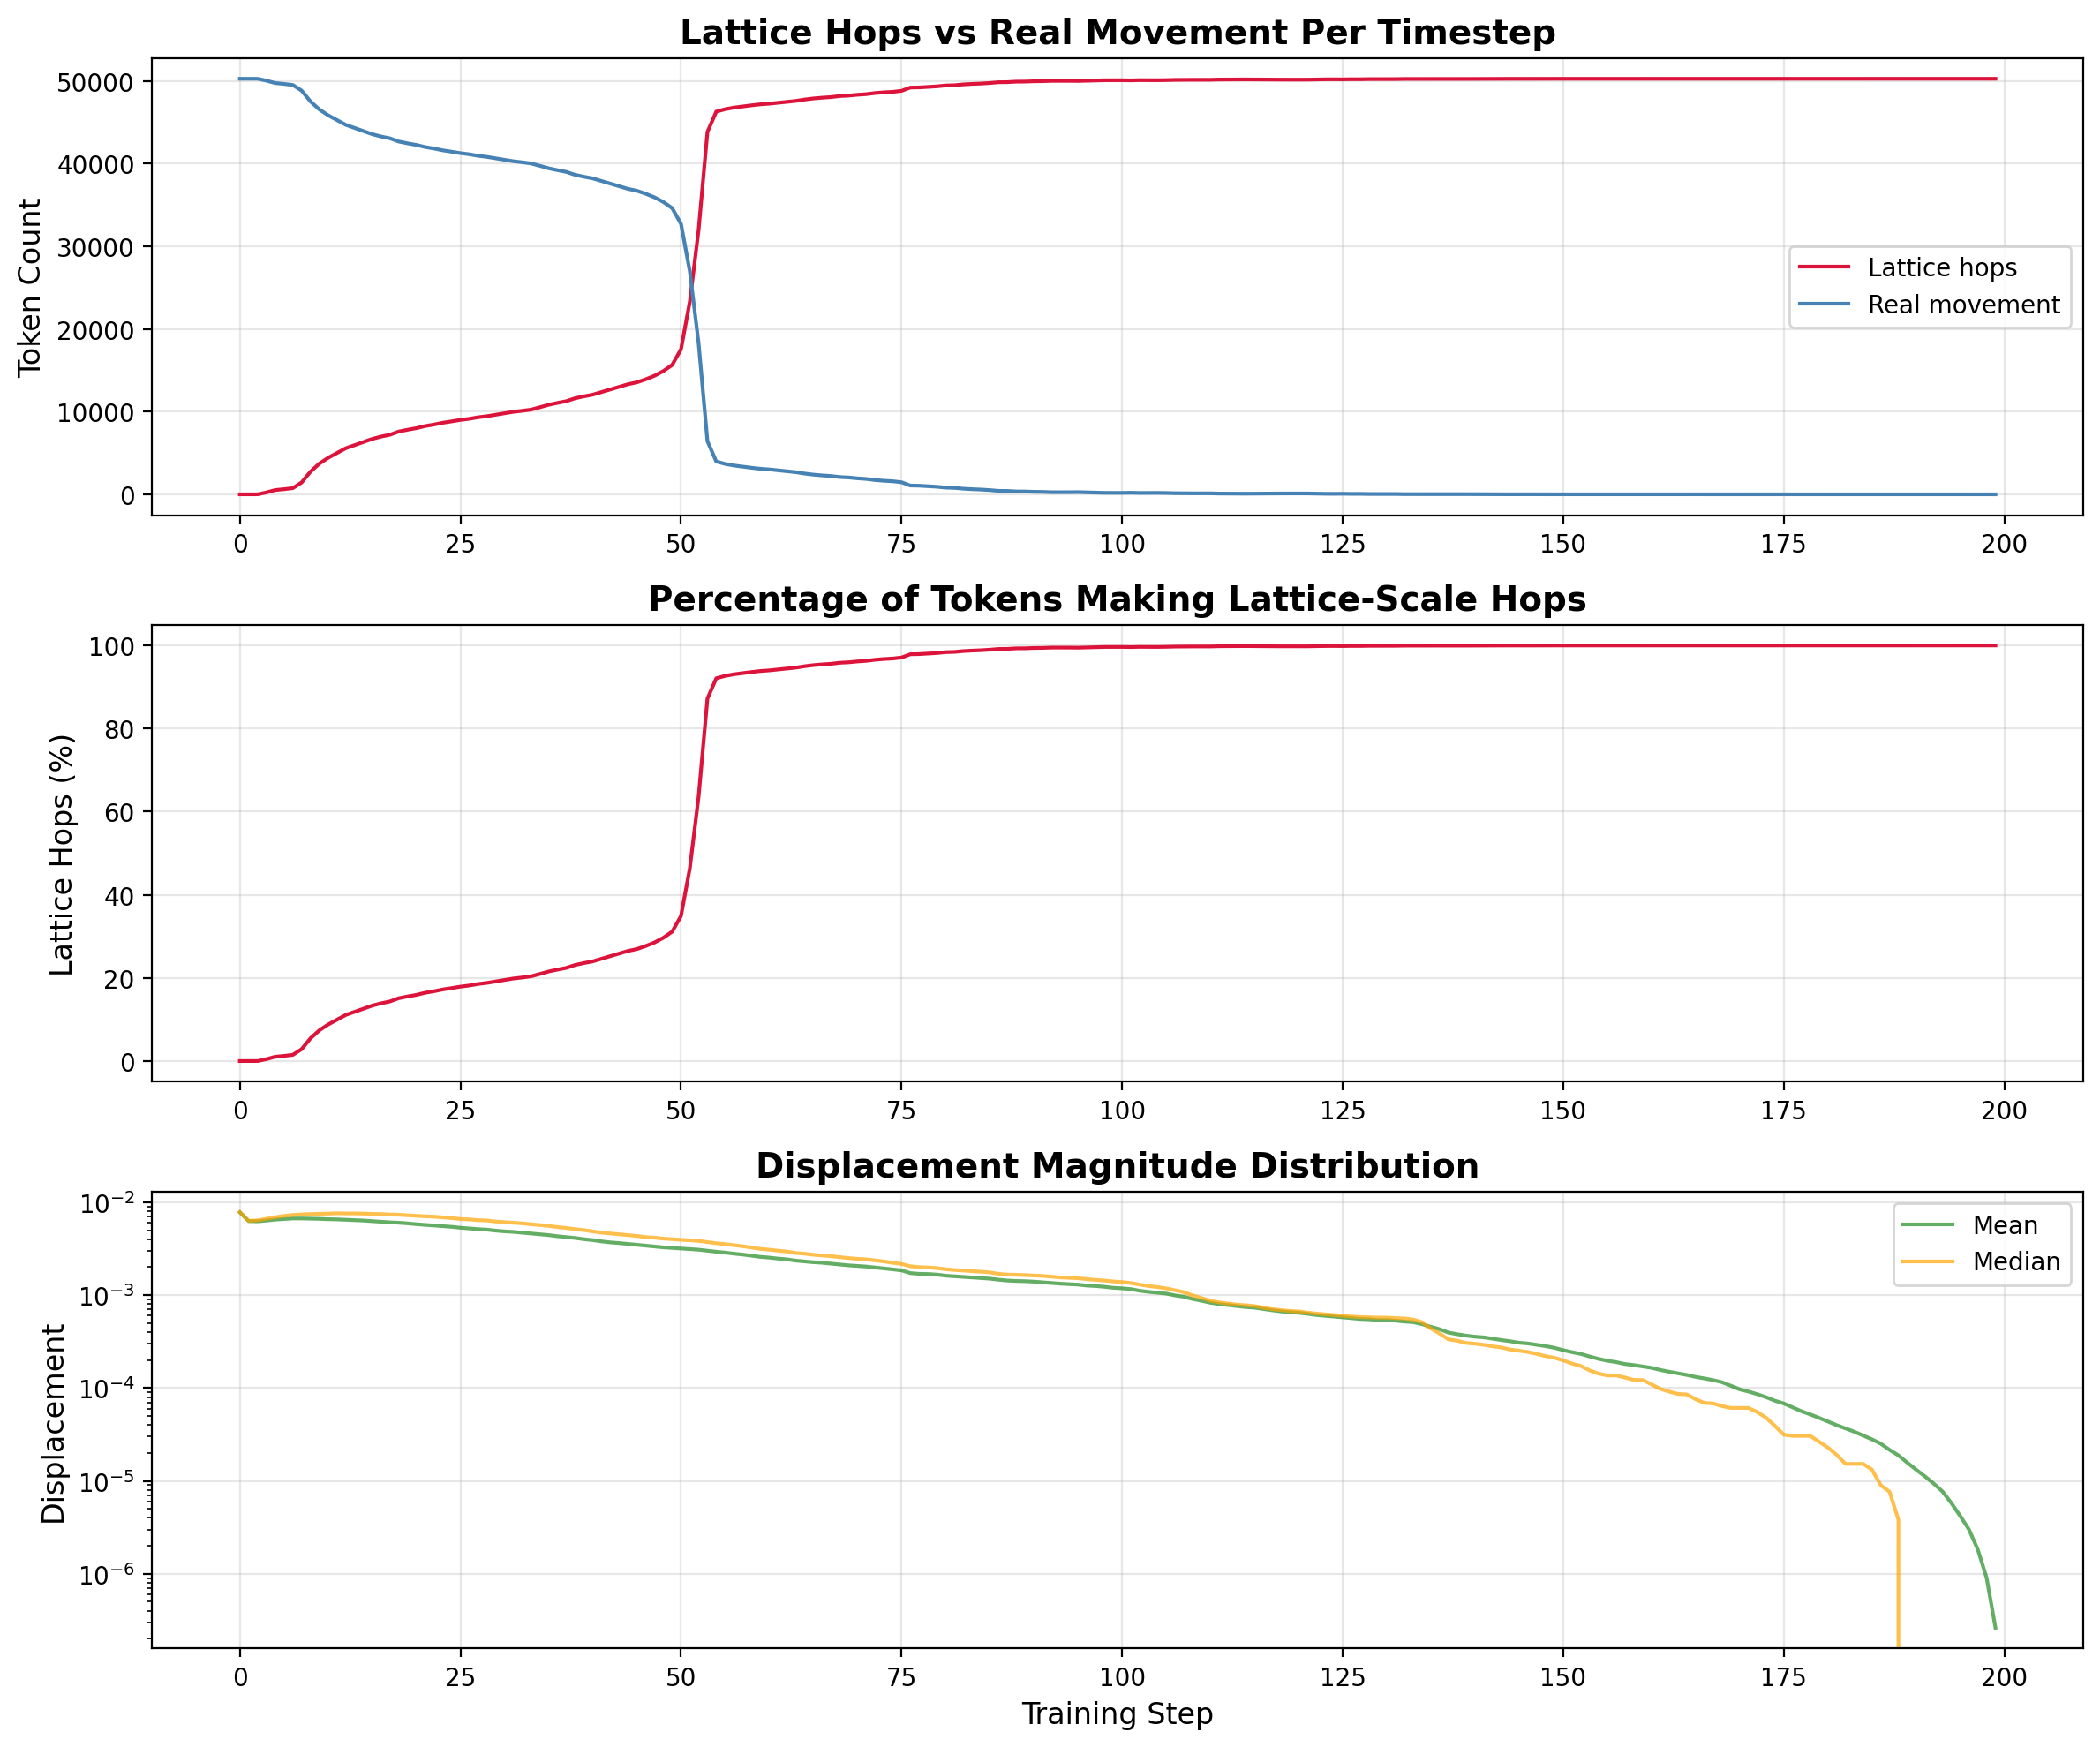

In [60]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), dpi=200)

steps = np.arange(len(lattice_hop_counts))

# Lattice hops vs real movement
axes[0].plot(steps, lattice_hop_counts, color='crimson', linewidth=1.5, label='Lattice hops')
axes[0].plot(steps, real_movement_counts, color='steelblue', linewidth=1.5, label='Real movement')
axes[0].set_ylabel('Token Count', fontsize=12)
axes[0].set_title('Lattice Hops vs Real Movement Per Timestep', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Percentage of tokens making lattice hops
axes[1].plot(steps, 100 * lattice_hop_counts / n_tokens, color='crimson', linewidth=1.5)
axes[1].set_ylabel('Lattice Hops (%)', fontsize=12)
axes[1].set_title('Percentage of Tokens Making Lattice-Scale Hops', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Mean displacement magnitude
axes[2].semilogy(steps, mean_displacements, color='forestgreen', linewidth=1.5, label='Mean', alpha=0.7)
axes[2].semilogy(steps, median_displacements, color='orange', linewidth=1.5, label='Median', alpha=0.7)
axes[2].set_ylabel('Displacement', fontsize=12)
axes[2].set_xlabel('Training Step', fontsize=12)
axes[2].set_title('Displacement Magnitude Distribution', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 3: Distribution Analysis

Let's look at a few specific timesteps to understand the displacement distribution.

NameError: name 'get_max_exponent' is not defined

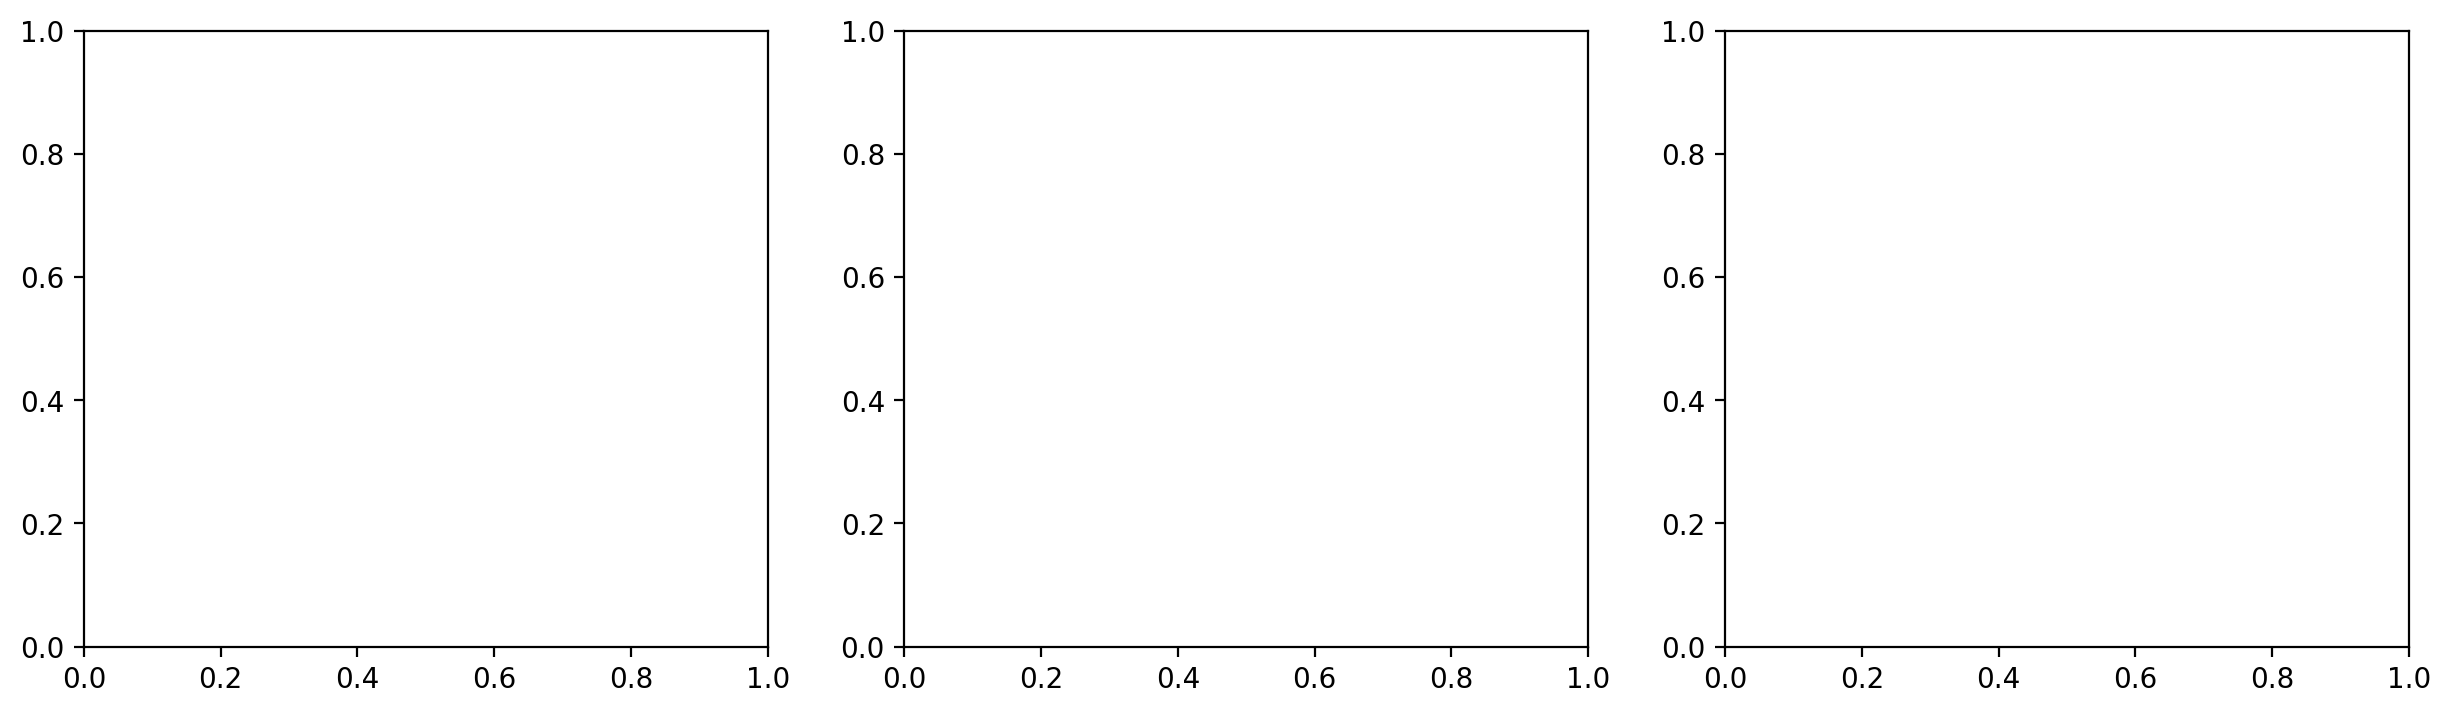

In [61]:
# Pick three representative timesteps: early, middle, late
timesteps_to_analyze = [0, 50, 99]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), dpi=200)

for idx, t in enumerate(timesteps_to_analyze):
    with torch.no_grad():
        W_t = W[t]
        W_t1 = W[t+1]
        displacements = torch.linalg.norm(W_t1 - W_t, dim=1).cpu().float().numpy()
        
        # Compute typical ULP scale for reference
        sample_token = W_t[0]
        max_exp = get_max_exponent(sample_token)
        ulp = compute_ulp_at_exponent(max_exp)
        epsilon = ulp * EPSILON_MULTIPLIER
        
        axes[idx].hist(displacements, bins=100, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
        axes[idx].axvline(epsilon, color='crimson', linewidth=2, linestyle='--', label=f'ε = {epsilon:.2e}')
        axes[idx].set_xlabel('Displacement', fontsize=11)
        axes[idx].set_ylabel('Count', fontsize=11)
        axes[idx].set_title(f'Step {t} → {t+1}', fontsize=12, fontweight='bold')
        axes[idx].set_yscale('log')
        axes[idx].legend(fontsize=9)
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Red line shows typical lattice threshold (ε = 8 × ULP) for first token.")
print("Tokens to the left of the line made lattice-scale hops.")
print("Tokens to the right made real gradient-driven movements.")

## Conclusion

This analysis reveals:
- How many tokens are "frozen" by bfloat16 quantization at each timestep
- When gradient updates become smaller than lattice spacing
- The transition from "active training" to "thermal jitter"

If we see increasing lattice hops over time, it confirms that gradients shrink below the quantization threshold—the "freezing" phenomenon we hypothesized.